<a id=top-page></a>
# `pykitPIV` demo: Setup a reinforcement learning environment for a virtual particle image velocimetry (PIV) setup

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>

</ol>
<p></p>
</div>
<br>

***

In [52]:
from pykitPIV.ml import PIVEnv, Rewards, Cues
from pykitPIV.flowfield import compute_q_criterion, compute_divergence, compute_vorticity
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import sys, os
import time

In [2]:
save_images = False
filename = None

***

## Prepare specifications for pykitPIV parameters 

Specifications can be dictionaries or objects of the appropriate configuration classes from pykitPIV.
Below, we create both examples. 

Let's start with dictionaries:

In [4]:
particle_spec = {'diameters': (1, 1),
                 'distances': (2, 2),
                 'densities': (0.4, 0.4),
                 'diameter_std': 1,
                 'seeding_mode': 'random'}

flowfield_spec = {'size': (200, 500),
                  'time_separation': 2,
                  'flowfield_type': 'random smooth',
                  'gaussian_filters': (10, 10),
                  'n_gaussian_filter_iter': 10,
                  'displacement': (2, 2)}

motion_spec = {'n_steps': 10,
               'particle_loss': (0, 0),
               'particle_gain': (0, 0)}

image_spec = {'exposures': (0.98, 0.98),
              'maximum_intensity': 2**16-1,
              'laser_beam_thickness': 1,
              'laser_over_exposure': 1,
              'laser_beam_shape': 0.95,
              'alpha': 1/8,
              'clip_intensities': True,
              'normalize_intensities': False}

Otherwise, specifications can be objects of the appropriate configuration classes:

In [5]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=1,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=1,
seeding_mode='random',
random_seed=None)


In [6]:
flowfield_spec = FlowFieldSpecs(size=(200, 500), 
                                time_separation=2,
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 500),
size_buffer=10,
time_separation=2,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [7]:
motion_spec = MotionSpecs(n_steps=10,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
particle_loss=(0, 0),
particle_gain=(0, 0),
random_seed=None)


In [8]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False)


Use LIMA as an inference model:

In [12]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [13]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [14]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


***

## Create the RL environment

Define the cues that the RL agent effectively senses and learns from:

In [15]:
def cues_function(displacement_field_tensor):

    mean_displacement = np.mean(displacement_field_tensor)
    max_displacement = np.max(displacement_field_tensor)
    min_displacement = np.min(displacement_field_tensor)
    
    cues = np.array([[mean_displacement, max_displacement, min_displacement]])

    return cues

Initialize the `Gymnasium` environment:

In [16]:
env = PIVEnv(interrogation_window_size=(60,60),
             interrogation_window_size_buffer=10,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=lima_inference_model,
             random_seed=None)

We first reset the environment to create the first starting position for the interrogation window that the virtual PIV camera is centered at.

The user can `reset()` the environment to a randomly assigned position:

In [38]:
camera_position, cues = env.reset()

Or to an imposed position, say 75px along the height and 50px along the width of the virtual wind tunnel:

In [39]:
camera_position, cues = env.reset(imposed_camera_position=(75,50))

***

## Rendering the environment

Without specifying the quantity to plot, the function `render()` visualizes the displacement field magnitude, $|d \vec{\mathbf{s}}|$. It also 

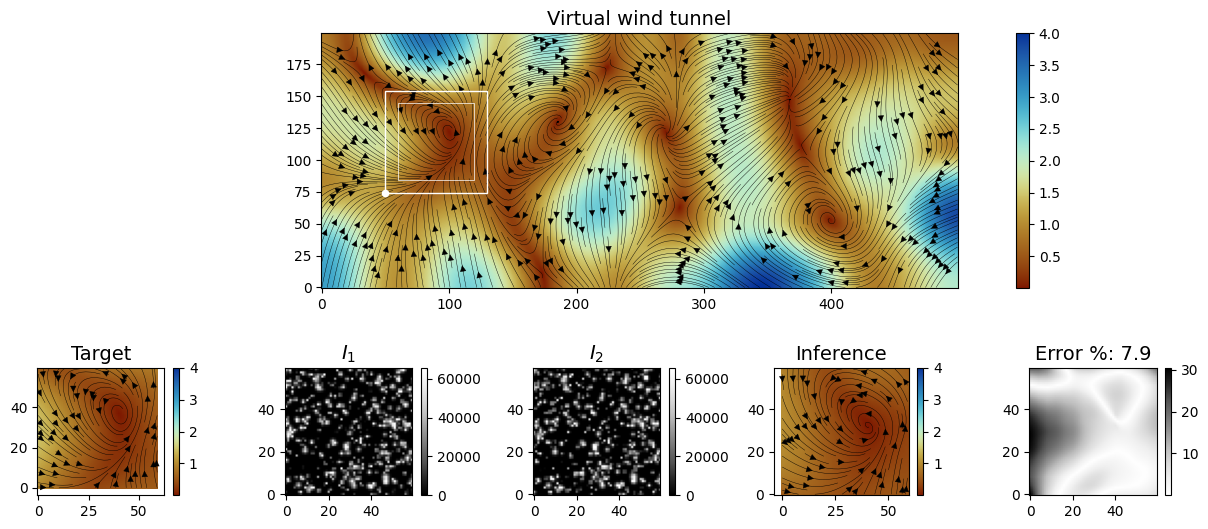

In [40]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-ds-magnitude.png'
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=filename)

If the user is only interested in visualizing the flow field in the virtual wind tunnel, we can switch off plotting of the camera position (`camera_position = False`) and switch off plotting the PIV details under the interrogation window (`wind_tunnel_only = True`).

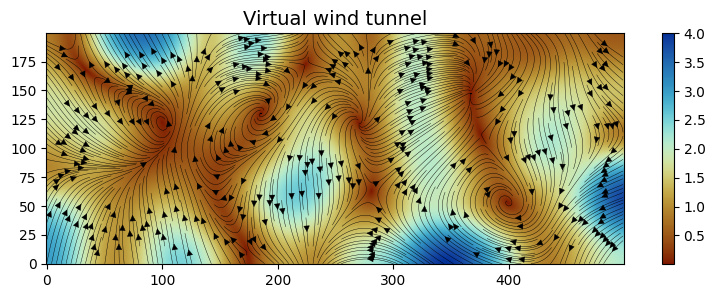

In [45]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-ds-magnitude-wt-only.png'
plt = env.render(quantity=None,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

We can also specify a different quantity to plot in the virtual wind tunnel. It can be, for example, the velocity field magnitude:

In [46]:
quantity = env.flowfield.velocity_field_magnitude[0,0,:,:]
quantity.shape

(200, 500)

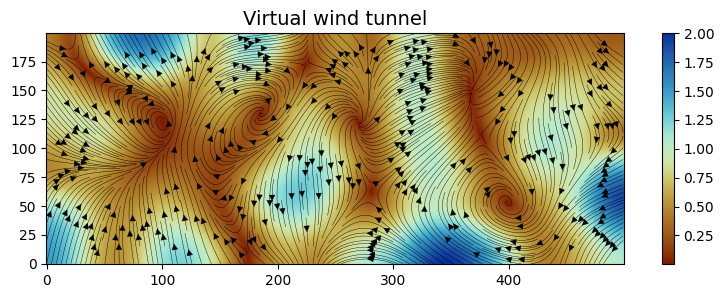

In [49]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-velocity-magnitude.png'
plt = env.render(quantity=quantity,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

In this case, since the time separation, $\Delta t$, between image frames is 2, the maximum displacement field magnitude is 4, whereas the maximum velocity field is magnitude. This follows from $d\vec{\mathbf{s}} = [dx, dy] = [u \Delta t, v \Delta t]$.

The plotted quantity can also be the learned policy computed after training the RL agent. This helps visualize the quality of training.

Alternatively, one can also plot various characteristics of the velocity field in the virtual wind tunnel, such as the divergence, vorticity, or the Q-criterion.

Here's the example of visualizing the Q-criterion, which can help locate vortices:

In [33]:
q_criterion = compute_q_criterion(env.flowfield.velocity_field, edge_order=1)[0,:,:]
q_criterion.shape

(200, 500)

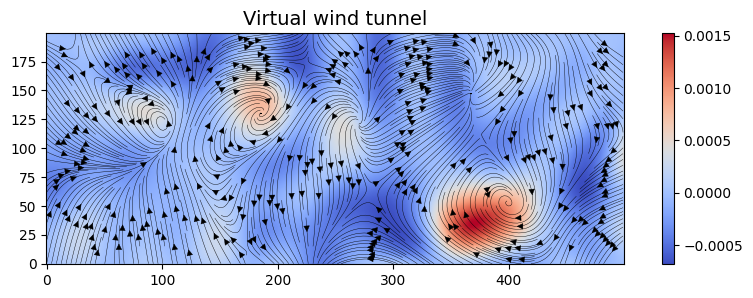

In [53]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-Q-criterion.png'
plt = env.render(quantity=q_criterion,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=False,
                 cmap='coolwarm',
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

Here's another example of visualizing the divergence:

In [54]:
divergence = compute_divergence(env.flowfield.velocity_field, edge_order=1)[0,:,:]
divergence.shape

(200, 500)

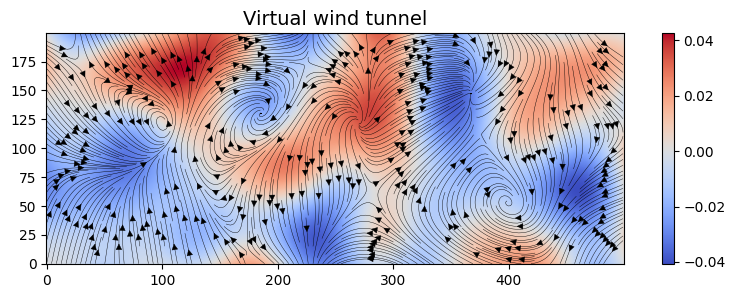

In [56]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-divergence.png'
plt = env.render(quantity=divergence,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=False,
                 cmap='coolwarm',
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

***

## Stepping in the environment

Test making 10 random steps in the environment:

In [ ]:
rewards = Rewards(verbose=False)
reward_function = rewards.q_criterion

In [ ]:
def reward_transformation(Q):
    Q = np.max(Q.clip(min=0))
    return Q

In [ ]:
for _ in range(0,5):

    action = np.random.choice(5)

    print(action)
    
    camera_position, cues, reward = env.step(action, 
                                             reward_function=reward_function,
                                             reward_transformation=reward_transformation,
                                             verbose=True)

    

In [ ]:
# plt = env.render(camera_position,
#                  c='white',
#                  s=20,
#                  lw=1,
#                  normalize_cbars=True,
#                  cmap=cmc.roma,
#                  add_streamplot=True,
#                  streamplot_density=3,
#                  streamplot_color='k',
#                  streamplot_linewidth=0.3,
#                  figsize=(15,6), 
#                  filename=None)

Reset the environment with a user-defined initial camera position:

In [ ]:
camera_position, cues = env.reset(imposed_camera_position=np.array([0, 50]))

plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=None)

***